# Asking Humans for Help: Customizing State in LangGraph

Hướng dẫn này trình bày cách mở rộng chatbot bằng LangGraph bằng cách thêm một **"nút người dùng"**, cho phép hệ thống tùy chọn yêu cầu sự trợ giúp từ con người. Nó giới thiệu tùy chỉnh trạng thái với cờ "ask_human" và cho thấy cách xử lý các gián đoạn và cập nhật trạng thái thủ công. Hướng dẫn này cũng bao gồm trực quan hóa đồ thị, logic có điều kiện và tích hợp các công cụ như tìm kiếm web và hỗ trợ từ con người.


In [3]:
from dotenv import load_dotenv
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel
from langchain_ollama import ChatOllama
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import TavilySearchResults

_ = load_dotenv(dotenv_path='../.env')

###### Define the State ######
class State(TypedDict):
    messages: Annotated[list, add_messages]
    ask_human: bool

class HumanRequest(BaseModel):
    """Forward the conversation to an expert. Use when you can't assist directly or the user needs assistance that exceeds your authority.
    To use this function, pass the user's 'request' so that an expert can provide appropriate guidance.
    """

    request: str
    
tool = TavilySearchResults(max_results=3)
tools =[tool, HumanRequest]
llm = ChatOllama(model='qwen2.5:7b', temperature=0)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    # Generate a response using the LLM tool calls
    response = llm_with_tools.invoke(state["messages"])

    # Initialize the ask_human flag
    ask_human = False

    # If there is a tool call and its name is 'HumanRequest'
    if response.tool_calls and response.tool_calls[0]["name"] == HumanRequest.__name__:
        ask_human = True

    # Return the messages and the ask_human state
    return {"messages": [response], "ask_human": ask_human}


# Initialize the state graph
graph_builder = StateGraph(State)

# Add the chatbot node
graph_builder.add_node("chatbot", chatbot)

# Add the tools node
graph_builder.add_node("tools", ToolNode(tools=[tool]))

## Setting Up the Human Node

Tiếp theo, chúng ta tạo nút `human`.

Nút này chủ yếu đóng vai trò là một chỗ giữ chỗ để kích hoạt ngắt trong đồ thị. Nếu người dùng không cập nhật trạng thái thủ công trong quá trình `interrupt`, LLM sẽ chèn một thông báo công cụ để cho biết rằng người dùng đã được yêu cầu trợ giúp nhưng không phản hồi.

Nút này cũng đặt lại cờ `ask_human` để đảm bảo đồ thị không truy cập lại nút trừ khi có yêu cầu khác được thực hiện.

> Reference Image

![](../images/08-langgraph-state-customization.png)

In [4]:
from langchain_core.messages import AIMessage, ToolMessage

# Function to create a response message (for generating ToolMessage)
def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )

# Human node processing
def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # If there is no response from the human
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Add new messages
        "messages": new_messages,
        # Reset the flag
        "ask_human": False,
    }

# Add the human node to the graph
if "human" not in graph_builder.nodes: 
    graph_builder.add_node("human", human_node)

Tiếp theo, chúng ta định nghĩa logic điều kiện.

Hàm `select_next_node` định tuyến đường dẫn đến nút `human` nếu cờ được đặt. Nếu không, nó sử dụng hàm `tools_condition` được xây dựng sẵn để chọn nút tiếp theo.

Hàm `tools_condition` chỉ đơn giản kiểm tra xem `chatbot` có sử dụng `tool_calls` trong thông báo phản hồi hay không.

Nếu có, nó định tuyến đến nút `action`. Nếu không, nó kết thúc đồ thị.


In [5]:
from langgraph.graph import END

# Function to select the next node
def select_next_node(state: State):
    # Check if the chatbot should ask a human
    if state["ask_human"]:
        return "human"
    # Otherwise, follow the same path as before
    return tools_condition(state)

# Add conditional edges
graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

Finally, we connect the edges and compile the graph.

In [7]:
# Add edge: from 'tools' to 'chatbot'
graph_builder.add_edge("tools", "chatbot")

# Add edge: from 'human' to 'chatbot'
graph_builder.add_edge("human", "chatbot")

# Add edge: from START to 'chatbot'
graph_builder.add_edge(START, "chatbot")

# Initialize memory storage
memory = MemorySaver()

# Compile the graph: use memory checkpointing
graph = graph_builder.compile(
    checkpointer=memory,
    # Set interrupt before 'human'
    interrupt_before=["human"],
)

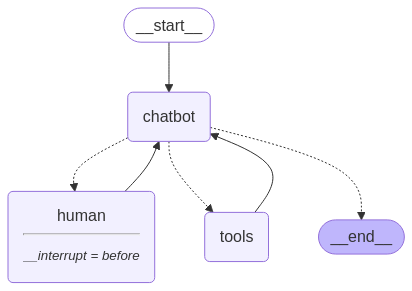

In [8]:
graph

Nút `chatbot` hoạt động như sau:

- Chatbot có thể yêu cầu sự trợ giúp từ con người (chatbot->select->human)
- Nó có thể gọi một công cụ tìm kiếm (chatbot->select->action)
- Hoặc nó có thể phản hồi trực tiếp (chatbot->select-> **end** ).

Khi một hành động hoặc yêu cầu được thực hiện, đồ thị chuyển trở lại nút `chatbot` để tiếp tục nhiệm vụ.


### Full code

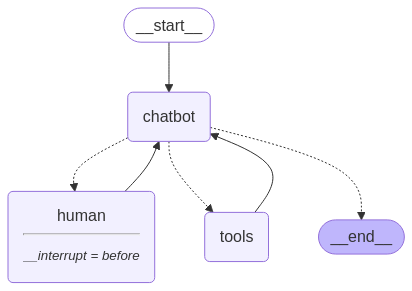

In [9]:
from dotenv import load_dotenv
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel
from langchain_ollama import ChatOllama
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import TavilySearchResults
from langchain_core.messages import AIMessage, ToolMessage


_ = load_dotenv(dotenv_path='../.env')

###### Define the State ######
class State(TypedDict):
    messages: Annotated[list, add_messages]
    ask_human: bool

class HumanRequest(BaseModel):
    """Forward the conversation to an expert. Use when you can't assist directly or the user needs assistance that exceeds your authority.
    To use this function, pass the user's 'request' so that an expert can provide appropriate guidance.
    """

    request: str
    
tool = TavilySearchResults(max_results=3)
tools =[tool, HumanRequest]
llm = ChatOllama(model='qwen2.5:7b', temperature=0)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    # Generate a response using the LLM tool calls
    response = llm_with_tools.invoke(state["messages"])

    # Initialize the ask_human flag
    ask_human = False

    # If there is a tool call and its name is 'HumanRequest'
    if response.tool_calls and response.tool_calls[0]["name"] == HumanRequest.__name__:
        ask_human = True

    # Return the messages and the ask_human state
    return {"messages": [response], "ask_human": ask_human}


# Initialize the state graph
graph_builder = StateGraph(State)

# Add the chatbot node
graph_builder.add_node("chatbot", chatbot)

# Add the tools node
graph_builder.add_node("tools", ToolNode(tools=[tool]))

# Function to create a response message (for generating ToolMessage)
def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )

# Human node processing
def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # If there is no response from the human
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Add new messages
        "messages": new_messages,
        # Reset the flag
        "ask_human": False,
    }

# Add the human node to the graph
if "human" not in graph_builder.nodes: 
    graph_builder.add_node("human", human_node)

# Function to select the next node
def select_next_node(state: State):
    # Check if the chatbot should ask a human
    if state["ask_human"]:
        return "human"
    # Otherwise, follow the same path as before
    return tools_condition(state)

# Add conditional edges
graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},)

# Add edge: from 'tools' to 'chatbot'
graph_builder.add_edge("tools", "chatbot")

# Add edge: from 'human' to 'chatbot'
graph_builder.add_edge("human", "chatbot")

# Add edge: from START to 'chatbot'
graph_builder.add_edge(START, "chatbot")

# Initialize memory storage
memory = MemorySaver()

# Compile the graph: use memory checkpointing
graph = graph_builder.compile(
    checkpointer=memory,
    # Set interrupt before 'human'
    interrupt_before=["human"],
)

graph

In [ ]:
from langchain_core.runnables import RunnableConfig
# user_input = "I need expert help to build this AI agent. Please search for an answer." (Case where it performs a web search instead of asking a human)
user_input = "I need expert help to build this AI agent. Can you request assistance?"

# Config setup
config = RunnableConfig(configurable={'thread_id':  '1'}) #{"configurable": {"thread_id": "1"}}

# Stream or call the second positional argument as configuration
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        # Pretty print the last message
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need expert help to build this AI agent. Can you request assistance?
================================== Ai Message ==================================
Tool Calls:
  HumanRequest (7b59770e-4e2f-41f2-bc7a-65735bf65a69)
 Call ID: 7b59770e-4e2f-41f2-bc7a-65735bf65a69
  Args:
    request: I need expert help to build this AI agent.


In [12]:
# Create a snapshot of the graph state
snapshot = graph.get_state(config)

# Access the next snapshot state
snapshot.next

('human',)

Trạng thái đồ thị thực sự bị **gián đoạn** trước nút `'human'`. Trong tình huống này, bạn có thể đóng vai trò là "chuyên gia" và cập nhật trạng thái thủ công bằng cách thêm một `ToolMessage` mới với đầu vào của bạn.

Để phản hồi yêu cầu của chatbot, hãy làm theo các bước sau:

1. Tạo một `ToolMessage` chứa phản hồi của bạn. Thông báo này sẽ được chuyển lại cho `chatbot`.
2. Gọi `update_state` để cập nhật trạng thái đồ thị thủ công.


In [13]:
# Extract the AI message
ai_message = snapshot.values["messages"][-1]

# Create a human response
human_response = (
    "Experts are here to help! We highly recommend checking out LangGraph for building your agent. "
    "It is much more stable and scalable than a simple autonomous agent. "
    "You can find more information at https://wikidocs.net/233785."
)

# Create a tool message
tool_message = create_response(human_response, ai_message)

# Update the graph state
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f00861e-e36b-6db9-8002-6e6448955d4f'}}

You can check the state to confirm that the response has been added.

In [14]:
# Get the message values from the graph state
graph.get_state(config).values["messages"]

[HumanMessage(content='I need expert help to build this AI agent. Can you request assistance?', additional_kwargs={}, response_metadata={}, id='8ea5dafa-a0b7-4845-ae91-3bf02aa752bf'),
 AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5:7b', 'created_at': '2025-03-24T03:39:42.545405089Z', 'done': True, 'done_reason': 'stop', 'total_duration': 29301034332, 'load_duration': 2474740318, 'prompt_eval_count': 288, 'prompt_eval_duration': 21877000000, 'eval_count': 29, 'eval_duration': 4941000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-94fb3262-6069-4f22-b723-33b4e4d0550c-0', tool_calls=[{'name': 'HumanRequest', 'args': {'request': 'I need expert help to build this AI agent.'}, 'id': '7b59770e-4e2f-41f2-bc7a-65735bf65a69', 'type': 'tool_call'}], usage_metadata={'input_tokens': 288, 'output_tokens': 29, 'total_tokens': 317}),
 ToolMessage(content='Experts are here to help! We highly recommend checking out Lang

Next, we **resume** the graph by passing `None` as the input.

In [15]:
# Generate an event stream from the graph
events = graph.stream(None, config, stream_mode="values")

# Process each event
for event in events:
    # Print the last message if messages are present
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

Experts are here to help! We highly recommend checking out LangGraph for building your agent. It is much more stable and scalable than a simple autonomous agent. You can find more information at https://wikidocs.net/233785.
================================= Tool Message =================================

Experts are here to help! We highly recommend checking out LangGraph for building your agent. It is much more stable and scalable than a simple autonomous agent. You can find more information at https://wikidocs.net/233785.
================================== Ai Message ==================================

Based on the advice from our experts, I recommend using LangGraph to build your AI agent. It's known for being more stable and scalable compared to simpler solutions. You can learn more about it [here](https://wikidocs.net/233785). If you need further assistance or have specific questions, feel free to as

In [16]:
# Check the final state
state = graph.get_state(config)

# Print the messages step by step
for message in state.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

I need expert help to build this AI agent. Can you request assistance?
================================== Ai Message ==================================
Tool Calls:
  HumanRequest (7b59770e-4e2f-41f2-bc7a-65735bf65a69)
 Call ID: 7b59770e-4e2f-41f2-bc7a-65735bf65a69
  Args:
    request: I need expert help to build this AI agent.
================================= Tool Message =================================

Experts are here to help! We highly recommend checking out LangGraph for building your agent. It is much more stable and scalable than a simple autonomous agent. You can find more information at https://wikidocs.net/233785.
================================== Ai Message ==================================

Based on the advice from our experts, I recommend using LangGraph to build your AI agent. It's known for being more stable and scalable compared to simpler solutions. You can learn more about it [here]